<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/main/influence_class_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# --- CONFIG: point these at your repo ---
REPO_URL = "https://github.com/cincysam6/Field_Control_Model.git"
REPO_DIR = "/content/Field_Control_Model"      # where to clone
PKG_ROOT = REPO_DIR                             # path to add to sys.path
REMOTE = "origin"
BRANCH = "main"                                 # or 'master' if you use that

# If your repo is private, set a token (or leave as None for public)
GITHUB_TOKEN = None  # e.g., "ghp_xxx..." or None for public

# ------------- helper: clone or pull -------------
import os, sys, subprocess, textwrap

def _run(cmd, cwd=None, check=True):
    print(" ".join(cmd))
    return subprocess.run(cmd, cwd=cwd, check=check, text=True, capture_output=True)

def ensure_repo(repo_url: str, repo_dir: str, remote="origin", branch="main", token=None, hard_reset=False):
    # Support private repos via token
    if token and repo_url.startswith("https://"):
        repo_url = repo_url.replace("https://", f"https://{token}@")

    if not os.path.exists(repo_dir):
        print(f"Cloning into {repo_dir} ...")
        _run(["git", "clone", "--recursive", repo_url, repo_dir])
    else:
        print(f"Repo exists at {repo_dir}. Fetching updates ...")
        _run(["git", "fetch", remote], cwd=repo_dir)
        if hard_reset:
            print(f"Hard resetting to {remote}/{branch} ...")
            _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)
        else:
            print("Pulling latest changes ...")
            # Fast-forward only; avoids merge prompts in Colab
            try:
                _run(["git", "pull", "--ff-only", remote, branch], cwd=repo_dir)
            except subprocess.CalledProcessError as e:
                print("Fast-forward failed (local changes?). Falling back to hard reset.")
                _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)

    # Ensure on the right branch
    _run(["git", "checkout", branch], cwd=repo_dir)

# ------------- do the fetch/pull -------------
ensure_repo(REPO_URL, REPO_DIR, remote=REMOTE, branch=BRANCH, token=GITHUB_TOKEN, hard_reset=False)

# ------------- put repo on sys.path -------------
if PKG_ROOT not in sys.path:
    sys.path.append(PKG_ROOT)

# ------------- turn on autoreload -------------
%load_ext autoreload
%autoreload 2

print("✅ Repo ready, path set, autoreload ON.")


Repo exists at /content/Field_Control_Model. Fetching updates ...
git fetch origin
Pulling latest changes ...
git pull --ff-only origin main
git checkout main
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Repo ready, path set, autoreload ON.


In [12]:
# 1. Clone your repo
#!git clone https://github.com/cincysam6/Field_Control_Model.git

# 2. Add it to Python path
import sys
#sys.path.append('/content/Field_Control_Model')

# 3. Import your helper function
from src.helpers import compute_distances_by_frame, pick_panel_kwargs,update_kwargs
from src.diagnostic_plots import plot_dir_orientation_small_multiples,diagnostic_plot,plot_field_control_small_multiples,diagnostic_multiples
from src.compute_player_density import compute_player_densities_dataframe
from src.plot_player_density import plot_player_densities_from_dataframe, plot_team_densities_small_multiples
from src.animate_plays import animate_pitch_control_with_players, animate_pitch_control_with_players_fast
from src.compute_player_density import compute_player_densities_team_control
from src.plot_player_density import visualize_team_control
from src.presets import default_kwargs, triangular_kwargs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [13]:
df = pd.read_csv('/content/Field_Control_Model/data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [14]:
# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-2934120900.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


In [15]:
### Selecting a single player ID to test this out
one_player = [40488.0]
single_player = df[df['nflId'].isin(one_player)]

In [16]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gamma


# ---------------------------------------------------------------------------
# Grid: small immutable container to carry X/Y meshgrids together
# ---------------------------------------------------------------------------

@dataclass(frozen=True)
class Grid:
    X: np.ndarray  # shape (ny, nx)
    Y: np.ndarray  # shape (ny, nx)

    @property
    def x_vals(self) -> np.ndarray:
        return self.X[0, :]

    @property
    def y_vals(self) -> np.ndarray:
        return self.Y[:, 0]


# ---------------------------------------------------------------------------
# PlayerInfluenceModel
#   Gaussian + Gamma mixture on a football field grid
# ---------------------------------------------------------------------------

class PlayerInfluenceModel:
    """
    Player influence density model (Gaussian + Gamma mixture) with tunable controls.

    Low‑speed behavior
    ------------------
    If `speed < low_speed_gaussian_cutoff`, the model **returns the Gaussian only**
    and forces it to be **perfectly isotropic** (no elongation leakage).
    """

    def __init__(
        self,
        grid_x_res: int = 200,
        grid_y_res: int = 100,
        field_x_max: float = 120.0,
        field_y_max: float = 53.3,
        *,
        # Global (keep bias OFF unless intentionally needed)
        orientation_bias_deg: float = 0.0,
        # Gaussian controls
        gaussian_scale_factor: float = 0.7,
        # Gamma controls
        alpha_gamma: float = 11.0,
        beta_min: float = 1.0,
        beta_max: float = 20.0,
        gamma_midpoint: float = 15.0,
        gamma_scale_factor: float = 0.8,
        max_forward_distance: float = 20.0,
        forward_decay_factor: float = 1.0,
        # Angular cone
        angle_limit_min: float = 15.0,
        angle_limit_max: float = 45.0,
        angle_decay_factor: float = 2.0,
        # Mixture weights (speed→weight logistic)
        w_gaussian_min: float = 0.2,
        w_gaussian_max: float = 1.0,
        gaussian_midpoint: float = 4.0,
        gaussian_steepness: float = 2.0,
        # NEW: low‑speed pure Gaussian cutoff (yd/s)
        low_speed_gaussian_cutoff: float = 2.0,
    ) -> None:
        # Grid / field
        self.grid_x_res = int(grid_x_res)
        self.grid_y_res = int(grid_y_res)
        self.field_x_max = float(field_x_max)
        self.field_y_max = float(field_y_max)
        x_vals = np.linspace(0.0, self.field_x_max, self.grid_x_res)
        y_vals = np.linspace(0.0, self.field_y_max, self.grid_y_res)
        X, Y = np.meshgrid(x_vals, y_vals)
        self.grid = Grid(X=X, Y=Y)

        # Hyperparameters
        self.orientation_bias_deg = float(orientation_bias_deg)

        self.gaussian_scale_factor = float(gaussian_scale_factor)

        self.alpha_gamma = float(alpha_gamma)
        self.beta_min = float(beta_min)
        self.beta_max = float(beta_max)
        self.gamma_midpoint = float(gamma_midpoint)
        self.gamma_scale_factor = float(gamma_scale_factor)
        self.max_forward_distance = float(max_forward_distance)
        self.forward_decay_factor = float(forward_decay_factor)

        self.angle_limit_min = float(angle_limit_min)
        self.angle_limit_max = float(angle_limit_max)
        self.angle_decay_factor = float(angle_decay_factor)

        self.w_gaussian_min = float(w_gaussian_min)
        self.w_gaussian_max = float(w_gaussian_max)
        self.gaussian_midpoint = float(gaussian_midpoint)
        self.gaussian_steepness = float(gaussian_steepness)

        self.low_speed_gaussian_cutoff = float(low_speed_gaussian_cutoff)

    # -----------------------------------------------------------------------
    # Angle helpers
    # -----------------------------------------------------------------------

    @staticmethod
    def _norm_deg(deg: float) -> float:
        return (deg % 360.0 + 360.0) % 360.0

    def theta_from_tracking(self, deg: float, *, apply_bias: bool = False) -> float:
        eff_deg = 90.0 - deg + (self.orientation_bias_deg if apply_bias else 0.0)
        return np.deg2rad(self._norm_deg(eff_deg))

    # -----------------------------------------------------------------------
    # Mixture weights as a function of speed
    # -----------------------------------------------------------------------

    def dynamic_weights(self, speed: float) -> Tuple[float, float]:
        """Logistic map from speed → (wG, wH), where wH = 1 - wG."""
        wG = self.w_gaussian_min + (self.w_gaussian_max - self.w_gaussian_min) / (
            1.0 + np.exp(self.gaussian_steepness * (speed - self.gaussian_midpoint))
        )
        return float(wG), float(1.0 - wG)

    # -----------------------------------------------------------------------
    # Gaussian component (elliptical local influence)
    # -----------------------------------------------------------------------

    @staticmethod
    def _radius_influence(dist_from_ball: float) -> float:
        """Baseline radius vs. distance to ball (caps ~3 yds)."""
        if dist_from_ball <= 18.0:
            return 1.0 + (3.0 / (18.0 ** 2)) * (dist_from_ball ** 2)
        return 3.0

    def _sigma(
        self,
        theta: float,
        speed: float,
        dist_from_ball: float,
        *,
        max_speed: float = 11.3,
    ) -> np.ndarray:
        """
        Rotated 2×2 covariance matrix for the Gaussian.
        - Elongates along heading with speed
        - **NEW**: Below cutoff, force isotropy (no elongation)
        """
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        # Speed modulation (squared ratio). Kill elongation when slow.
        ratio = 0.0 if speed < self.low_speed_gaussian_cutoff else float((speed ** 2) / (max_speed ** 2))

        base = self._radius_influence(dist_from_ball)
        sx = (base + base * ratio) * self.gaussian_scale_factor
        sy = max((base - base * ratio) * self.gaussian_scale_factor, sx * 0.5)

        S = np.array([[sx, 0.0], [0.0, sy]])
        cov = R @ (S ** 2) @ R.T
        cov += np.eye(2) * 1e-6
        return cov

    @staticmethod
    def _mu(pos_xy: Tuple[float, float], vel_xy: np.ndarray) -> np.ndarray:
        """Gaussian mean = current position + 0.5 * velocity (gentle forward nudge)."""
        return np.array(pos_xy, dtype=float) + 0.5 * vel_xy

    # -----------------------------------------------------------------------
    # Gamma anchor (origin behind player so mode sits near player)
    # -----------------------------------------------------------------------

    def compute_offset(
        self,
        pos_xy: Tuple[float, float],
        direction_deg: float,
        speed: float
    ) -> Tuple[float, float]:
        beta = self.beta_min + (self.beta_max - self.beta_min) / (1.0 + np.exp(1.0 * (speed - 1.0)))
        mode = (8.0 - 1.0) / beta  # mode of Gamma(k≈8, β)
        th = self.theta_from_tracking(direction_deg, apply_bias=False)
        return (pos_xy[0] - mode * np.cos(th), pos_xy[1] - mode * np.sin(th))

    # -----------------------------------------------------------------------
    # Core density (Gaussian + Gamma), normalized and mixed
    # -----------------------------------------------------------------------

    def base_distribution(
        self,
        pos_xy: Tuple[float, float],
        pos_off_xy: Tuple[float, float],
        direction_deg: float,
        speed: float,
        *,
        dist_from_ball: float,
        alpha_gamma: Optional[float] = None,
    ) -> np.ndarray:
        """
        Compute mixed influence Z = wG*G + wH*H on the model grid.
        **NEW**: if speed < cutoff → return G only (pure circular Gaussian).
        """
        X, Y = self.grid.X, self.grid.Y
        x_off, y_off = pos_off_xy
        th = self.theta_from_tracking(direction_deg, apply_bias=False)

        # Velocity and angular cone width (narrows with speed)
        vel = np.array([np.cos(th) * speed, np.sin(th) * speed], dtype=float)
        ang_lim_deg = self.angle_limit_min + (self.angle_limit_max - self.angle_limit_min) * np.exp(
            -speed / self.angle_decay_factor
        )

        # ----- Gaussian term -----
        cov = self._sigma(th, speed, dist_from_ball)
        mu = self._mu(pos_xy, vel)
        G = multivariate_normal(mean=mu, cov=cov).pdf(np.dstack((X, Y)))
        G /= G.max() if G.max() > 0 else 1.0  # normalize to [0,1]

        # **NEW: low-speed guard — pure Gaussian, isotropic**
        if speed < self.low_speed_gaussian_cutoff:
            return G

        # ----- Gamma term (forward) -----
        beta_dyn = self.beta_min + (self.beta_max - self.beta_min) * (speed / self.gamma_midpoint)
        beta_dyn = np.clip(beta_dyn, self.beta_min, self.beta_max)

        dx, dy = X - x_off, Y - y_off
        d_proj = dx * np.cos(th) + dy * np.sin(th)                      # distance along heading
        d_scaled = d_proj / max(speed * (1.0 + speed / 18.0), 1e-3)     # speed-scaled axis

        a = float(self.alpha_gamma if alpha_gamma is None else alpha_gamma)
        H = gamma.pdf(d_scaled, a=a, scale=1.0 / (beta_dyn * self.gamma_scale_factor))

        # Soft cap fade
        mask_far = d_proj > self.max_forward_distance
        if np.any(mask_far):
            fade = self.forward_decay_factor if self.forward_decay_factor > 0 else 1.0
            H[mask_far] *= np.exp(
                -((d_proj[mask_far] - self.max_forward_distance) ** 2)
                / (2.0 * (speed * fade) ** 2 + 1e-6)
            )

        # Soft angular gate near heading
        ang_to_pt = np.arctan2(dy, dx)
        ang_diff = np.abs((ang_to_pt - th + np.pi) % (2.0 * np.pi) - np.pi)
        H *= 1.0 / (1.0 + np.exp(10.0 * (ang_diff - np.radians(ang_lim_deg))))

        H /= H.max() if H.max() > 0 else 1.0

        # ----- Mix with speed‑dependent weights -----
        wG, wH = self.dynamic_weights(speed)
        Z = wG * G + wH * H
        return Z

    # -----------------------------------------------------------------------
    # Batch per frame
    # -----------------------------------------------------------------------

    def compute_influence(
        self,
        df: pd.DataFrame,
        frame_id: int,
        player_ids: Optional[Iterable[int]] = None,
        *,
        id_col: str = "nflId",
        name_col: str = "displayName",
        x_col: str = "x",
        y_col: str = "y",
        speed_col: str = "s",
        dir_col: str = "dir",
        dist_from_ball_col: str = "dist_from_football",
        density_out_col: str = "density_grid",
    ) -> pd.DataFrame:
        """Compute per‑player influence grids for a single frame."""
        f = df.loc[df["frameId"] == frame_id].copy()
        if player_ids is not None:
            if isinstance(player_ids, (int, float, str)):
                player_ids = [player_ids]
            f = f[f[id_col].isin(player_ids)].copy()
        if name_col in f.columns:
            f = f[f[name_col].str.lower() != "football"].copy()

        required = {id_col, x_col, y_col, speed_col, dir_col, dist_from_ball_col}
        missing = required - set(f.columns)
        if missing:
            raise KeyError(f"Missing required columns in df: {sorted(missing)}")

        out_rows = []
        for _, r in f.iterrows():
            pos = (float(r[x_col]), float(r[y_col]))
            dir_deg = float(r[dir_col])
            spd = float(r[speed_col])
            dball = float(r[dist_from_ball_col])

            pos_off = self.compute_offset(pos, dir_deg, spd)
            Z = self.base_distribution(
                pos_xy=pos,
                pos_off_xy=pos_off,
                direction_deg=dir_deg,
                speed=spd,
                dist_from_ball=dball,
            )
            rec = r.to_dict()
            rec[density_out_col] = Z
            out_rows.append(rec)

        return pd.DataFrame(out_rows)


In [17]:

model = PlayerInfluenceModelDev(**triangular_kwargs)

# 1) Compute influence for exactly one player in one frame
player_id = 40488.0
frame_id  = 150

single = model.compute_influence(
    df=df,                         # your tracking rows for the play
    frame_id=frame_id,
    player_ids=[player_id],
    id_col="nflId",
    name_col="displayName",
    x_col="x",
    y_col="y",
    speed_col="s",
    dir_col="dir",
    dist_from_ball_col="dist_from_football",
    density_out_col="density"      # put the 2D array here
)

# 2) Pull out the 2D density array for this (frame, player)
if single.empty:
    raise ValueError("No rows returned; check frame_id/player_id.")
Z = single.iloc[0]["density"]          # shape (ny, nx), a NumPy array

# 3) Turn the density into a neat table with x/y coordinates as index/columns
X, Y = model.grid.X, model.grid.Y
density_table = pd.DataFrame(Z, index=model.grid.y_vals, columns=model.grid.x_vals)

# Optional: a tiny summary “table” of stats for this player/frame
stats = pd.DataFrame({
    "frameId": [frame_id],
    "nflId": [player_id],
    "sum_density": [float(Z.sum())],
    "max_density": [float(Z.max())],
    "center_of_mass_x": [float((X * Z).sum() / (Z.sum() + 1e-9))],
    "center_of_mass_y": [float((Y * Z).sum() / (Z.sum() + 1e-9))],
})

# What you now have:
# - `single` : one-row DataFrame with player/pose fields + the 'density' array
# - `density_table` : a tidy grid (rows=y, cols=x) suitable for inspection/plotting
# - `stats` : a compact summary for quick comparisons



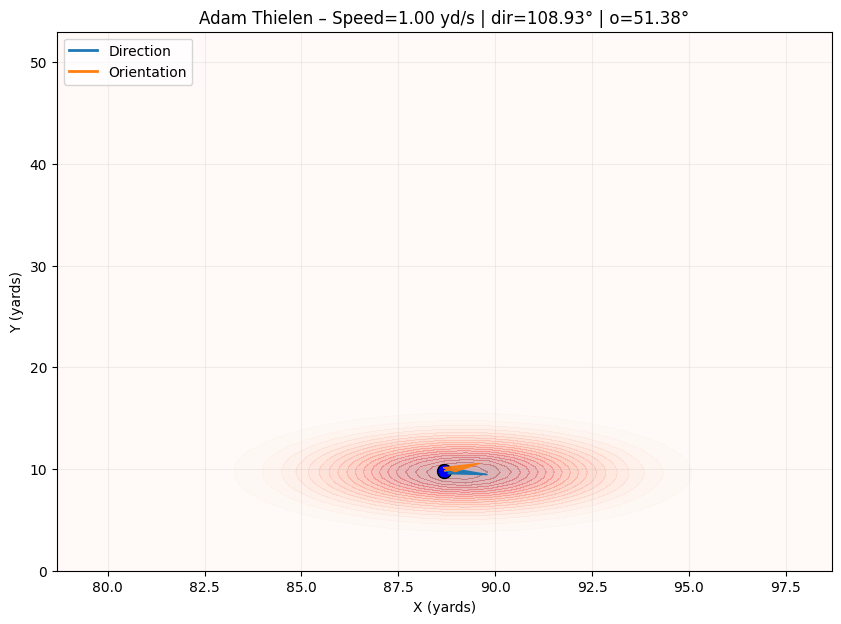

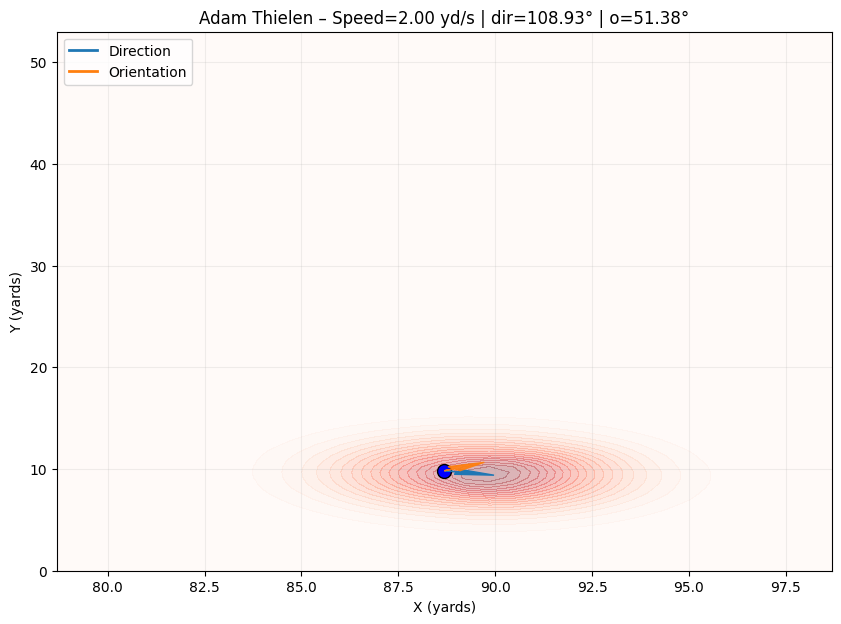

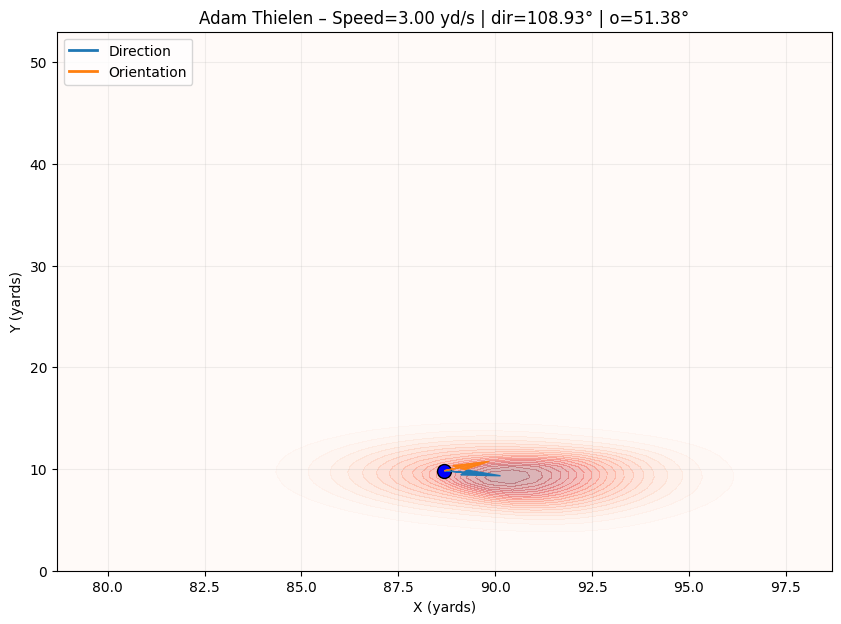

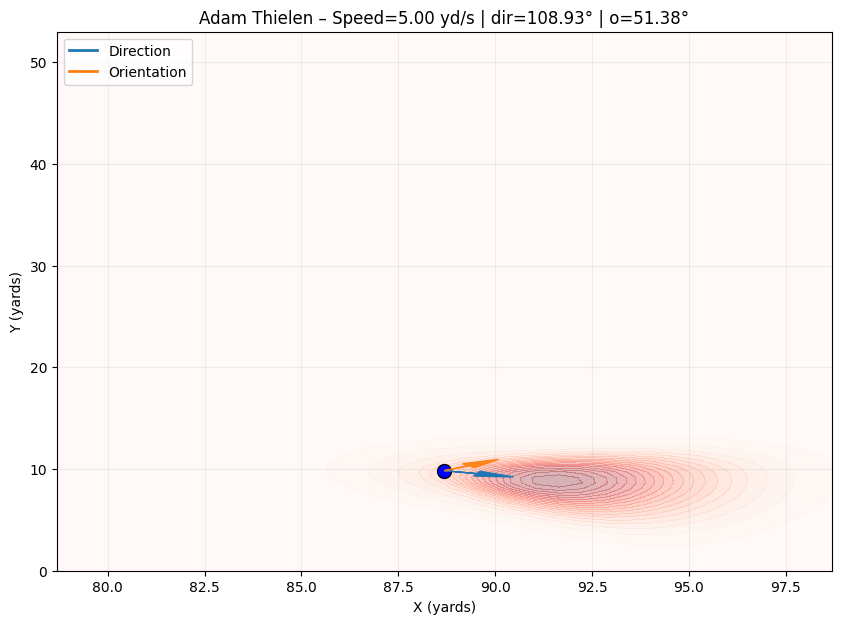

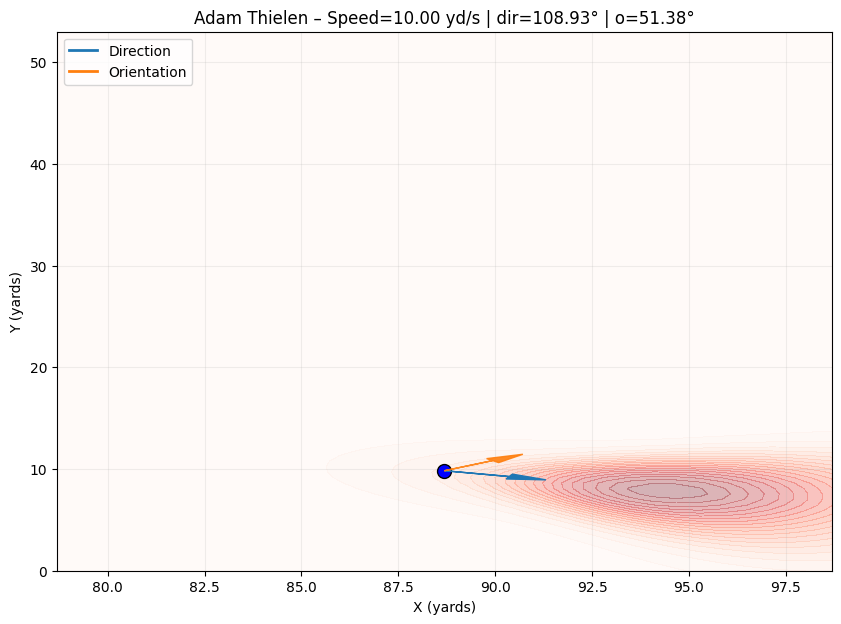

In [19]:

diagnostic_plot(df,
                frame_id=150,
                player_ids=[40488],
                speeds=(1,2,3,5,10),
                model_kwargs=triangular_kwargs,
                arrow_scale=2.0,    # instead of 5.0
                arrow_head_width=0.5,
                arrow_head_length=1.0,)
